# Form 5500 EDA - Benefits Insurance Analysis

Exploratory Data Analysis of Department of Labor Form 5500 filings to support company clustering and benefits insurance scoring.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## Data Loading

We use raw data files for accurate company counts and processed data for detailed analysis. The raw data (2020-2024) is more reliable for filing counts.

In [2]:
# Define paths
RAW_DATA_DIR = 'form-5500-data/raw/form_5500/'
DATA_DIR = 'form-5500-data/processed/'
OUTPUT_DIR = 'eda_output/'

# Load dimension tables (smaller files)
dim_naics = pd.read_csv(f'{DATA_DIR}dim_naics.csv')
dim_company = pd.read_csv(f'{DATA_DIR}dim_company.csv')

# Sample large fact tables to avoid memory issues
print("Loading fact_filing sample...")
fact_filing = pd.read_csv(f'{DATA_DIR}fact_filing-001.csv', nrows=500000)
print(f"Fact filing sample shape: {fact_filing.shape}")

print("Loading fact_carrier sample...")
fact_carrier = pd.read_csv(f'{DATA_DIR}fact_carrier.csv', nrows=500000)
print(f"Fact carrier sample shape: {fact_carrier.shape}")

print("Loading fact_provider sample...")
fact_provider = pd.read_csv(f'{DATA_DIR}fact_provider.csv', nrows=200000)
print(f"Fact provider sample shape: {fact_provider.shape}")

Loading fact_filing sample...
Fact filing sample shape: (500000, 85)
Loading fact_carrier sample...
Fact carrier sample shape: (500000, 63)
Loading fact_provider sample...
Fact provider sample shape: (200000, 42)


## Question 1: How Many Companies File Each Year? (2020-2024)

Using raw data files to get accurate counts per year.

In [3]:
# Load raw data for years 2020-2024 to count unique companies filing each year
years = [2020, 2021, 2022, 2023, 2024]
yearly_stats = []

for year in years:
    file_path = f"{RAW_DATA_DIR}F_5500_{year}_LATEST_FULL.csv"
    try:
        # Read only needed columns to save memory
        df = pd.read_csv(file_path, usecols=['SPONS_DFE_EIN'])
        num_filings = len(df)
        num_companies = df['SPONS_DFE_EIN'].nunique()
        yearly_stats.append({
            'year': year,
            'num_filings': num_filings,
            'num_companies': num_companies
        })
        print(f"{year}: {num_companies:,} companies, {num_filings:,} filings")
    except Exception as e:
        print(f"Error loading {year}: {e}")

yearly_df = pd.DataFrame(yearly_stats)
print("\n=== Companies Filing Form 5500 by Year (Raw Data) ===")
print(yearly_df)

2020: 156,805 companies, 249,623 filings
2021: 155,304 companies, 244,211 filings
2022: 155,289 companies, 243,804 filings
2023: 146,403 companies, 230,009 filings
2024: 126,620 companies, 187,191 filings

=== Companies Filing Form 5500 by Year (Raw Data) ===
   year  num_filings  num_companies
0  2020       249623         156805
1  2021       244211         155304
2  2022       243804         155289
3  2023       230009         146403
4  2024       187191         126620


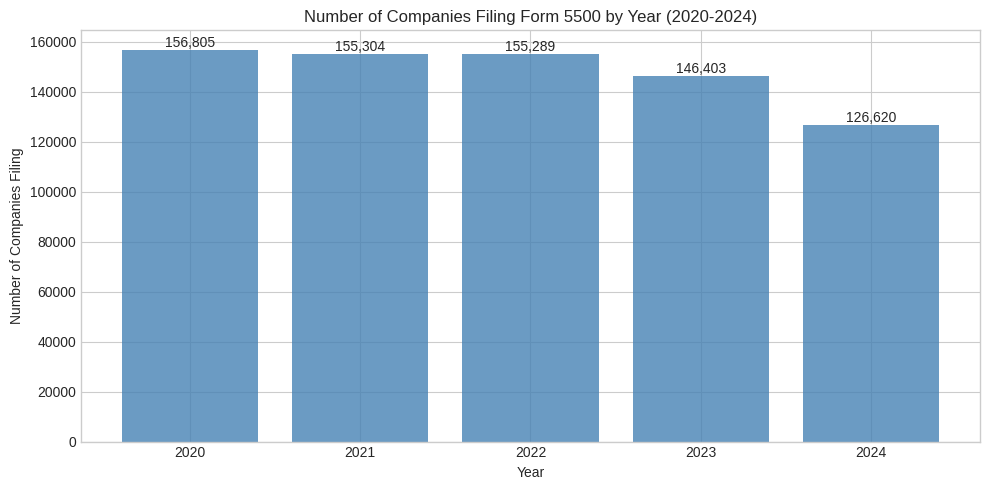

In [4]:
# Plot yearly company counts
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(yearly_df['year'], yearly_df['num_companies'], color='steelblue', alpha=0.8)
ax.set_xlabel('Year')
ax.set_ylabel('Number of Companies Filing')
ax.set_title('Number of Companies Filing Form 5500 by Year (2020-2024)')
for i, row in yearly_df.iterrows():
    ax.annotate(f'{row["num_companies"]:,.0f}', 
                xy=(row['year'], row['num_companies']),
                ha='center', va='bottom', fontsize=10)
ax.set_xticks(yearly_df['year'])
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}companies_filing_by_year.png', dpi=150)
plt.show()

## Question 2: Size Range by Enrolled Employees - Logical Size Bins

In [5]:
# Examine plan_size categories
print("Plan Size Distribution (from processed data):")
print(fact_filing['plan_size'].value_counts())

# Look at actual participant counts
print("\nTotal All Participants Statistics:")
print(fact_filing['total_all_participants'].describe())

Plan Size Distribution (from processed data):
plan_size
small    357987
large    142013
Name: count, dtype: int64

Total All Participants Statistics:
count    5.000000e+05
mean     1.826399e+02
std      5.769927e+03
min      0.000000e+00
25%      3.000000e+00
50%      1.100000e+01
75%      3.500000e+01
max      2.680395e+06
Name: total_all_participants, dtype: float64


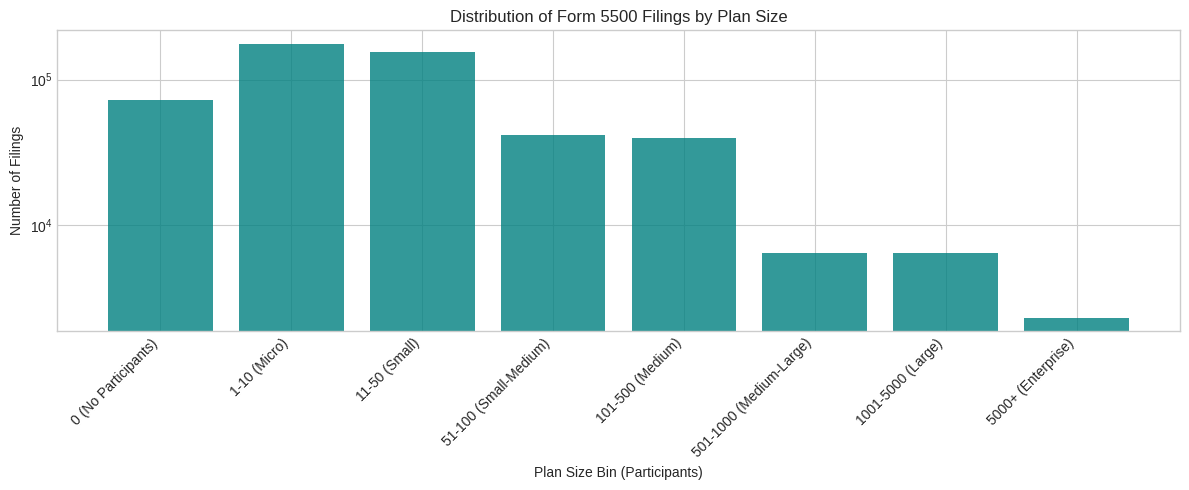


Filing counts by size bin:
size_bin
0 (No Participants)         72793
1-10 (Micro)               175647
11-50 (Small)              155233
51-100 (Small-Medium)       41515
101-500 (Medium)            39476
501-1000 (Medium-Large)      6506
1001-5000 (Large)            6504
5000+ (Enterprise)           2326
Name: count, dtype: int64


In [6]:
# Create size bins based on participant counts
fact_filing['participant_count'] = fact_filing['total_all_participants'].fillna(0)

def create_size_bin(count):
    if count == 0:
        return '0 (No Participants)'
    elif count <= 10:
        return '1-10 (Micro)'
    elif count <= 50:
        return '11-50 (Small)'
    elif count <= 100:
        return '51-100 (Small-Medium)'
    elif count <= 500:
        return '101-500 (Medium)'
    elif count <= 1000:
        return '501-1000 (Medium-Large)'
    elif count <= 5000:
        return '1001-5000 (Large)'
    else:
        return '5000+ (Enterprise)'

fact_filing['size_bin'] = fact_filing['participant_count'].apply(create_size_bin)

# Define order for plotting
size_order = ['0 (No Participants)', '1-10 (Micro)', '11-50 (Small)', '51-100 (Small-Medium)', 
               '101-500 (Medium)', '501-1000 (Medium-Large)', '1001-5000 (Large)', '5000+ (Enterprise)']

size_dist = fact_filing['size_bin'].value_counts().reindex(size_order).dropna()

fig, ax = plt.subplots(figsize=(12, 5))
bars = ax.bar(range(len(size_dist)), size_dist.values, color='teal', alpha=0.8)
ax.set_xticks(range(len(size_dist)))
ax.set_xticklabels(size_dist.index, rotation=45, ha='right')
ax.set_xlabel('Plan Size Bin (Participants)')
ax.set_ylabel('Number of Filings')
ax.set_title('Distribution of Form 5500 Filings by Plan Size')
ax.set_yscale('log')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}size_distribution.png', dpi=150)
plt.show()

print("\nFiling counts by size bin:")
print(size_dist)

In [7]:
# Check if the 'plan_size' field in data matches any standard classification
print("Plan Size field values (from data):")
print(fact_filing['plan_size'].value_counts())

# Compare with company-level size from dim_company
print("\nCompany-level plan size distribution:")
print(dim_company['plan_size'].value_counts())

Plan Size field values (from data):
plan_size
small    357987
large    142013
Name: count, dtype: int64

Company-level plan size distribution:
plan_size
small    862033
large    151961
mixed     49221
Name: count, dtype: int64


## Question 3: Primary Industry from NAICS Codes

### Understanding NAICS Structure

NAICS codes are 6-digit codes where:
- First 2 digits = Sector
- First 3 digits = Subsector
- First 4 digits = Industry Group
- First 5 digits = NAICS Industry
- Full 6 digits = National Industry

In [8]:
# Examine NAICS dimension table
print("NAICS Dimension Table:")
print(dim_naics.head(20))
print(f"\nTotal NAICS codes: {len(dim_naics)}")

# Sector distribution in NAICS lookup
print("\nSector Distribution (NAICS lookup):")
print(dim_naics['sector_name'].value_counts())

NAICS Dimension Table:
    naics_code                                      industry_name  \
0         2361                  Residential Building Construction   
1         2362               Nonresidential Building Construction   
2         3361                        Motor Vehicle Manufacturing   
3         3363                  Motor Vehicle Parts Manufacturing   
4         4411                                 Automobile Dealers   
5         4412                        Other Motor Vehicle Dealers   
6         4413  Automotive Parts, Accessories, and Tire Retailers   
7         4451                  Grocery and Convenience Retailers   
8         4452                           Specialty Food Retailers   
9         4453                   Beer, Wine, and Liquor Retailers   
10        4471                                  Gasoline Stations   
11        4521                                  Department Stores   
12        4523  General Merchandise Stores, including Warehous...   
13        4

In [9]:
# Create sector mapping from dim_naics
# First, ensure we have proper string conversion for business codes
dim_naics['naics_code_str'] = dim_naics['naics_code'].astype(str).str.zfill(6)
dim_naics['sector_code'] = dim_naics['naics_code_str'].str[:2]

# Create mapping from sector code to sector name
sector_map = dim_naics.drop_duplicates('sector_code')[['sector_code', 'sector_name']].set_index('sector_code')['sector_name'].to_dict()
print("Sector mapping:")
for k, v in sorted(sector_map.items()):
    print(f"  {k}: {v}")

Sector mapping:
  00: Construction
  02: Construction
  03: Manufacturing
  04: Retail Trade
  05: Information
  06: Health Care and Social Assistance
  07: Accommodation and Food Services
  08: Other Services (except Public Administration)
  23: Construction
  33: Manufacturing
  44: Retail Trade
  45: Retail Trade
  48: Transportation and Warehousing
  49: Transportation and Warehousing
  51: Information
  52: Finance and Insurance
  54: Professional, Scientific, and Technical Services
  62: Health Care and Social Assistance
  72: Accommodation and Food Services
  81: Other Services (except Public Administration)


In [10]:
# Business codes in filing data - map to sector
print("Business Code (NAICS) distribution in filings:")
business_code_dist = fact_filing['business_code'].value_counts().head(20)
print(business_code_dist)

# Map sector from business code - need to handle NaN and conversion
def safe_extract_sector(x):
    if pd.isna(x):
        return None
    try:
        code_str = str(int(x))
        if len(code_str) >= 2:
            return code_str[:2]
    except:
        pass
    return None

fact_filing['sector_code'] = fact_filing['business_code'].apply(safe_extract_sector)

# Map to sector name
fact_filing['sector'] = fact_filing['sector_code'].map(sector_map)

print("\nSector mapping results:")
print(f"Total filings: {len(fact_filing)}")
print(f"Filings with sector mapped: {fact_filing['sector'].notna().sum()}")
print(f"Filings without sector: {fact_filing['sector'].isna().sum()}")

Business Code (NAICS) distribution in filings:
business_code
621111.0    32269
621210.0    22643
541990.0    21457
541110.0    20926
611000.0    10737
541600.0    10427
813000.0    10012
812990.0     9932
238900.0     9815
523900.0     8058
524210.0     7291
541330.0     7069
238220.0     5985
541211.0     5499
236200.0     5342
339900.0     5042
236110.0     5040
541519.0     4942
441110.0     4796
624100.0     4735
Name: count, dtype: int64

Sector mapping results:
Total filings: 500000
Filings with sector mapped: 388266
Filings without sector: 111734


Sector Distribution in Filings:
sector
Professional, Scientific, and Technical Services    98207
Health Care and Social Assistance                   91577
Construction                                        42586
Manufacturing                                       33196
Other Services (except Public Administration)       31422
Finance and Insurance                               31151
Retail Trade                                        29822
Transportation and Warehousing                      10924
Accommodation and Food Services                      9793
Information                                          9588
Name: count, dtype: int64


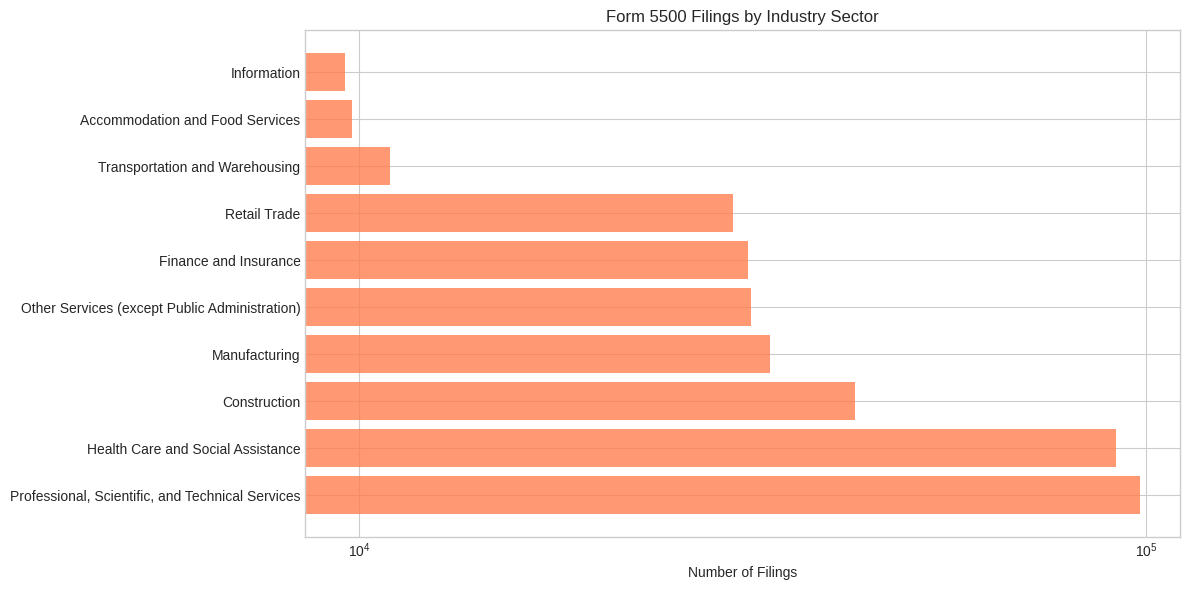

In [11]:
# Sector distribution in filings
sector_dist = fact_filing['sector'].value_counts()

print("Sector Distribution in Filings:")
print(sector_dist)

if len(sector_dist) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.barh(range(len(sector_dist)), sector_dist.values, color='coral', alpha=0.8)
    ax.set_yticks(range(len(sector_dist)))
    ax.set_yticklabels(sector_dist.index)
    ax.set_xlabel('Number of Filings')
    ax.set_title('Form 5500 Filings by Industry Sector')
    ax.set_xscale('log')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}sector_distribution.png', dpi=150)
    plt.show()
else:
    print("No sector data available for visualization")

In [12]:
# Companies with multiple NAICS codes - look at company-level data
print("Examining companies with filings across multiple business codes...")

# Get unique business codes per company
company_naics = fact_filing.groupby('ein')['business_code'].apply(
    lambda x: list(set(x.dropna().astype(str)))
).reset_index()
company_naics['num_naics'] = company_naics['business_code'].apply(len)

print("\nNumber of NAICS codes per company:")
print(company_naics['num_naics'].value_counts().sort_index().head(10))

# Companies with multiple NAICS
multi_naics = company_naics[company_naics['num_naics'] > 1]
print(f"\nCompanies with multiple NAICS codes: {len(multi_naics)} ({100*len(multi_naics)/len(company_naics):.1f}%)")

Examining companies with filings across multiple business codes...

Number of NAICS codes per company:
num_naics
0       1573
1     410979
2       7172
3        132
4          9
5          4
6          1
7          1
16         1
Name: count, dtype: int64

Companies with multiple NAICS codes: 7320 (1.7%)


In [13]:
# Analyze co-occurring NAICS codes
from collections import defaultdict

naics_pairs = []
for codes in multi_naics['business_code']:
    if len(codes) >= 2:
        # Get first 3 digits (subsector) for grouping
        subsectors = list(set([c[:3] for c in codes if len(str(c)) >= 3]))
        if len(subsectors) >= 2:
            for pair in combinations(sorted(subsectors), 2):
                naics_pairs.append(pair)

pair_counts = Counter(naics_pairs)
print("Most common co-occurring NAICS subsector pairs:")
for pair, count in pair_counts.most_common(15):
    print(f"  {pair[0]} + {pair[1]}: {count}")

Most common co-occurring NAICS subsector pairs:
  541 + 561: 149
  541 + 621: 92
  236 + 238: 85
  237 + 238: 83
  331 + 332: 82
  624 + 813: 81
  621 + 624: 79
  238 + 541: 72
  332 + 333: 69
  511 + 541: 57
  541 + 813: 56
  332 + 339: 51
  423 + 541: 49
  621 + 623: 49
  621 + 622: 49


Companies in top sectors with multiple sector filings: 1383


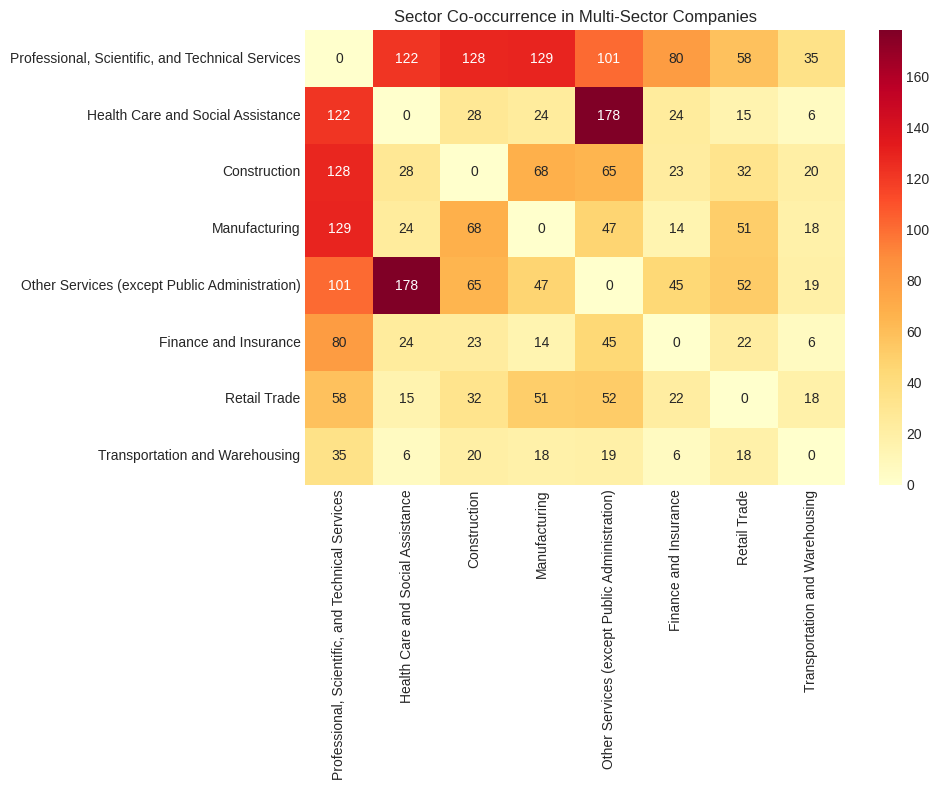

In [14]:
# Create a co-occurrence matrix for sectors (only if we have sector data)
if len(sector_dist) >= 2:
    top_sectors = sector_dist.head(8).index.tolist()
    
    # Get filings with sector info
    filing_sectors = fact_filing[fact_filing['sector'].isin(top_sectors)][['ein', 'sector']].drop_duplicates()
    
    # Create co-occurrence
    company_sectors = filing_sectors.groupby('ein')['sector'].apply(list).reset_index()
    company_multi_sector = company_sectors[company_sectors['sector'].apply(len) > 1]
    
    print(f"Companies in top sectors with multiple sector filings: {len(company_multi_sector)}")
    
    if len(company_multi_sector) > 0:
        # Sector co-occurrence
        sector_cooccur = defaultdict(int)
        for sectors in company_multi_sector['sector']:
            for pair in combinations(sorted(set(sectors)), 2):
                sector_cooccur[pair] += 1
        
        # Create heatmap matrix
        sector_names = top_sectors
        cooccur_matrix = pd.DataFrame(0, index=sector_names, columns=sector_names)
        for (s1, s2), count in sector_cooccur.items():
            if s1 in sector_names and s2 in sector_names:
                cooccur_matrix.loc[s1, s2] = count
                cooccur_matrix.loc[s2, s1] = count
        
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.heatmap(cooccur_matrix, annot=True, fmt='d', cmap='YlOrRd', ax=ax)
        ax.set_title('Sector Co-occurrence in Multi-Sector Companies')
        plt.tight_layout()
        plt.savefig(f'{OUTPUT_DIR}sector_cooccurrence.png', dpi=150)
        plt.show()
    else:
        print("Not enough multi-sector companies to create co-occurrence matrix")
else:
    print("Not enough sector data to create co-occurrence analysis")

## Question 4: Total Benefits Programs Structure by Size and Industry

Welfare vs Pension Filing Types:
Welfare plans: 73677
Pension plans: 421818


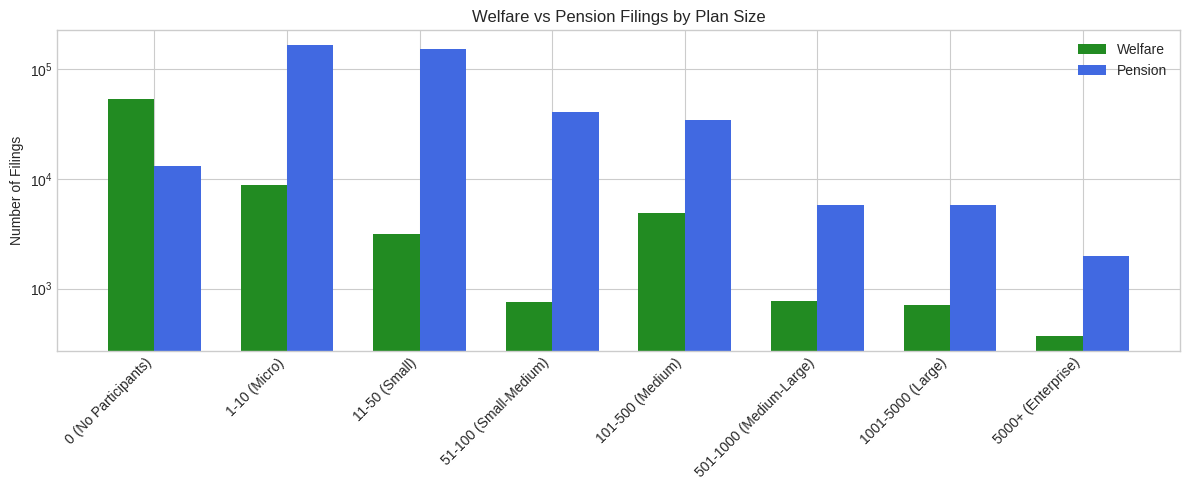

In [15]:
# Analyze welfare vs pension filings
print("Welfare vs Pension Filing Types:")
print(f"Welfare plans: {fact_filing['is_welfare'].sum()}")
print(f"Pension plans: {fact_filing['is_pension'].sum()}")

# Benefits programs by size
benefits_by_size = fact_filing.groupby('size_bin').agg({
    'is_welfare': 'sum',
    'is_pension': 'sum'
}).reindex(size_order).dropna()

if len(benefits_by_size) > 0:
    fig, ax = plt.subplots(figsize=(12, 5))
    x = range(len(benefits_by_size))
    width = 0.35
    ax.bar([i - width/2 for i in x], benefits_by_size['is_welfare'], width, label='Welfare', color='forestgreen')
    ax.bar([i + width/2 for i in x], benefits_by_size['is_pension'], width, label='Pension', color='royalblue')
    ax.set_xticks(x)
    ax.set_xticklabels(benefits_by_size.index, rotation=45, ha='right')
    ax.set_ylabel('Number of Filings')
    ax.set_title('Welfare vs Pension Filings by Plan Size')
    ax.legend()
    ax.set_yscale('log')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}benefits_by_size.png', dpi=150)
    plt.show()

Benefits by Sector (Top 10):
                                                  is_welfare  is_pension  \
sector                                                                     
Professional, Scientific, and Technical Services        8626       89682   
Health Care and Social Assistance                      10869       80936   
Construction                                            5812       36822   
Other Services (except Public Administration)           3277       28139   
Manufacturing                                           7695       25531   
Finance and Insurance                                   5256       25850   
Retail Trade                                            5058       24850   
Transportation and Warehousing                          2298        8630   
Information                                             1724        7859   
Accommodation and Food Services                         1988        7800   

                                                  num_comp

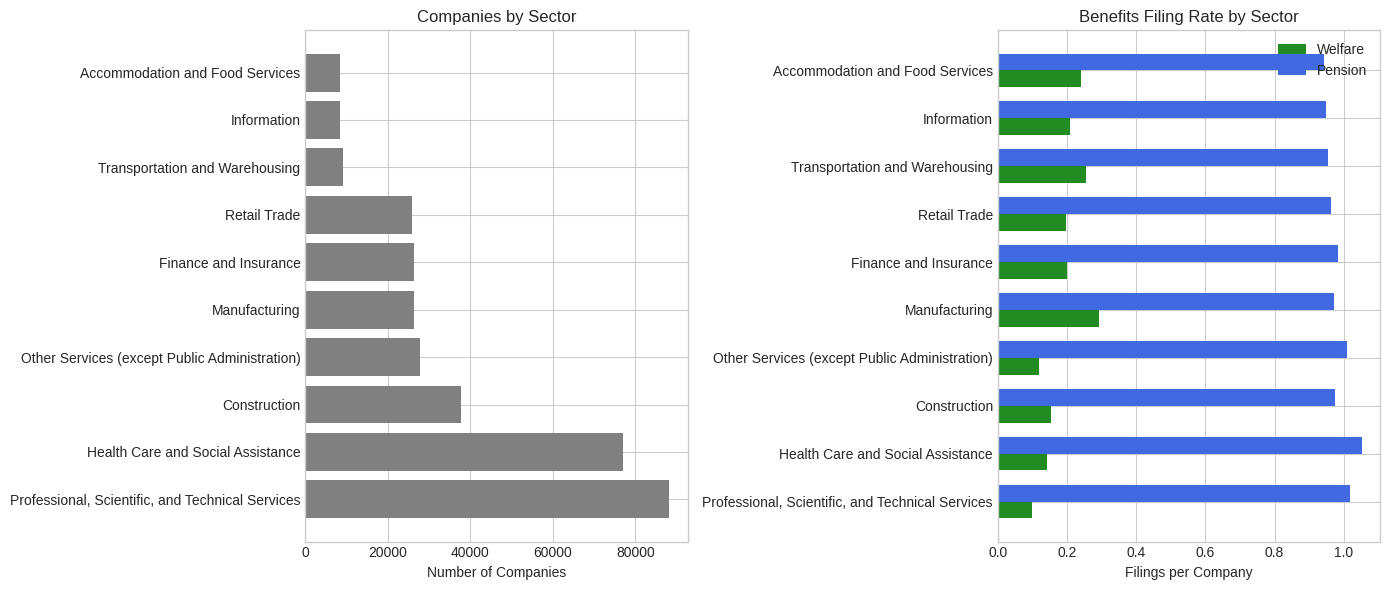

In [16]:
# Benefits by sector (only if we have sector data)
if len(sector_dist) > 0 and fact_filing['sector'].notna().sum() > 0:
    benefits_by_sector = fact_filing.groupby('sector').agg({
        'is_welfare': 'sum',
        'is_pension': 'sum',
        'ein': 'nunique'
    }).rename(columns={'ein': 'num_companies'})
    
    # Filter to only include sectors with data
    benefits_by_sector = benefits_by_sector[benefits_by_sector['num_companies'] > 0]
    
    if len(benefits_by_sector) > 0:
        benefits_by_sector['welfare_rate'] = benefits_by_sector['is_welfare'] / benefits_by_sector['num_companies']
        benefits_by_sector['pension_rate'] = benefits_by_sector['is_pension'] / benefits_by_sector['num_companies']
        benefits_by_sector = benefits_by_sector.sort_values('num_companies', ascending=False)
        
        print("Benefits by Sector (Top 10):")
        print(benefits_by_sector.head(10))
        
        # Plot
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        top_sectors_df = benefits_by_sector.head(10)
        axes[0].barh(range(len(top_sectors_df)), top_sectors_df['num_companies'], color='gray')
        axes[0].set_yticks(range(len(top_sectors_df)))
        axes[0].set_yticklabels(top_sectors_df.index)
        axes[0].set_xlabel('Number of Companies')
        axes[0].set_title('Companies by Sector')
        
        x = range(len(top_sectors_df))
        width = 0.35
        axes[1].barh([i - width/2 for i in x], top_sectors_df['welfare_rate'], width, label='Welfare', color='forestgreen')
        axes[1].barh([i + width/2 for i in x], top_sectors_df['pension_rate'], width, label='Pension', color='royalblue')
        axes[1].set_yticks(x)
        axes[1].set_yticklabels(top_sectors_df.index)
        axes[1].set_xlabel('Filings per Company')
        axes[1].set_title('Benefits Filing Rate by Sector')
        axes[1].legend()
        
        plt.tight_layout()
        plt.savefig(f'{OUTPUT_DIR}benefits_by_sector.png', dpi=150)
        plt.show()
    else:
        print("Not enough sector data for benefits analysis")
else:
    print("Sector data not available for benefits analysis")

## Question 5: Top Brokers and Carriers

In [17]:
# Top brokers by number of filings
top_brokers = fact_carrier['broker_name'].value_counts().head(20)
print("Top 20 Brokers by Number of Filings:")
print(top_brokers)

# Top carriers
top_carriers = fact_carrier['carrier_name'].value_counts().head(20)
print("\nTop 20 Carriers by Number of Filings:")
print(top_carriers)

Top 20 Brokers by Number of Filings:
broker_name
USI INSURANCE SERVICES LLC            12891
GALLAGHER BENEFIT SERVICES, INC.       9932
LOCKTON COMPANIES, LLC                 9861
MARSH & MCLENNAN AGENCY LLC            9492
MERCER HEALTH AND BENEFITS, LLC        6033
MERCER HEALTH & BENEFITS LLC           4788
WILLIS TOWERS WATSON US LLC            4306
ALLIANT INSURANCE SERVICES, INC.       3317
GALLAGHER BENEFIT SERVICES INC         3242
EDGEWOOD PARTNERS INSURANCE CENTER     2641
AON CONSULTING INC                     2437
DIGITAL INSURANCE LLC                  2008
HUB INTERNATIONAL MIDWEST LIMITED      1992
MERCER HEALTH AND BENEFITS LLC         1932
MCGRIFF INSURANCE SERVICES, INC.       1822
MARSH & MCLENNAN AGENCY, LLC           1820
AON CONSULTING INC.                    1773
LOCKTON COMPANIES LLC                  1721
ACRISURE LLC                           1709
AON CONSULTING                         1702
Name: count, dtype: int64

Top 20 Carriers by Number of Filings:
carrie

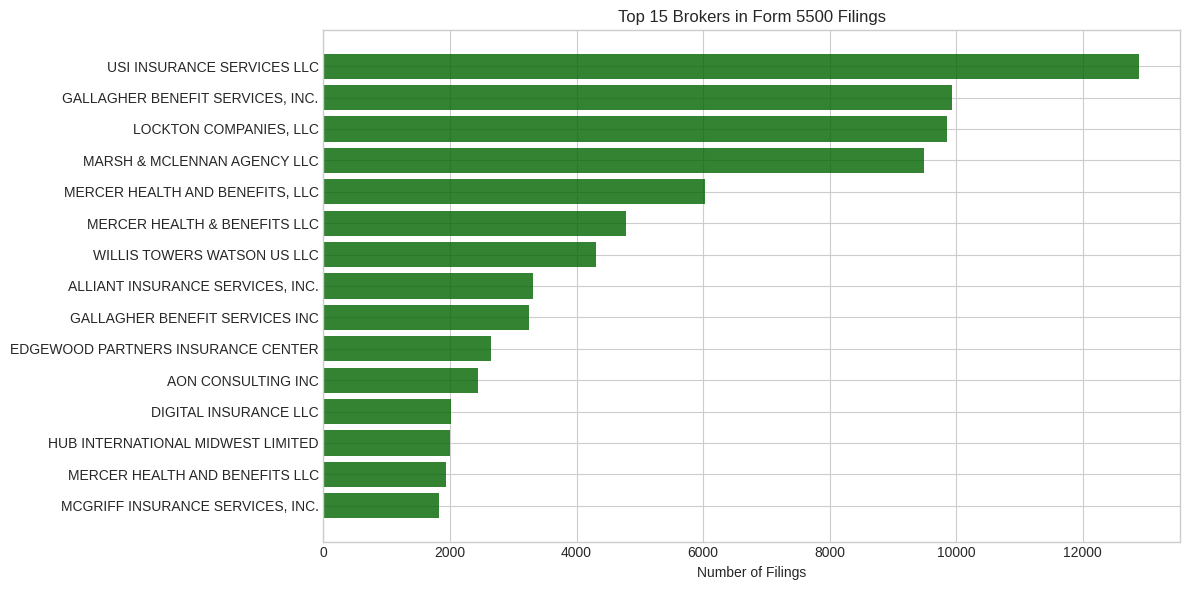

In [18]:
# Visualize top brokers
fig, ax = plt.subplots(figsize=(12, 6))
top_15_brokers = top_brokers.head(15)

bars = ax.barh(range(len(top_15_brokers)), top_15_brokers.values, color='darkgreen', alpha=0.8)
ax.set_yticks(range(len(top_15_brokers)))
ax.set_yticklabels(top_15_brokers.index)
ax.invert_yaxis()
ax.set_xlabel('Number of Filings')
ax.set_title('Top 15 Brokers in Form 5500 Filings')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}top_brokers.png', dpi=150)
plt.show()

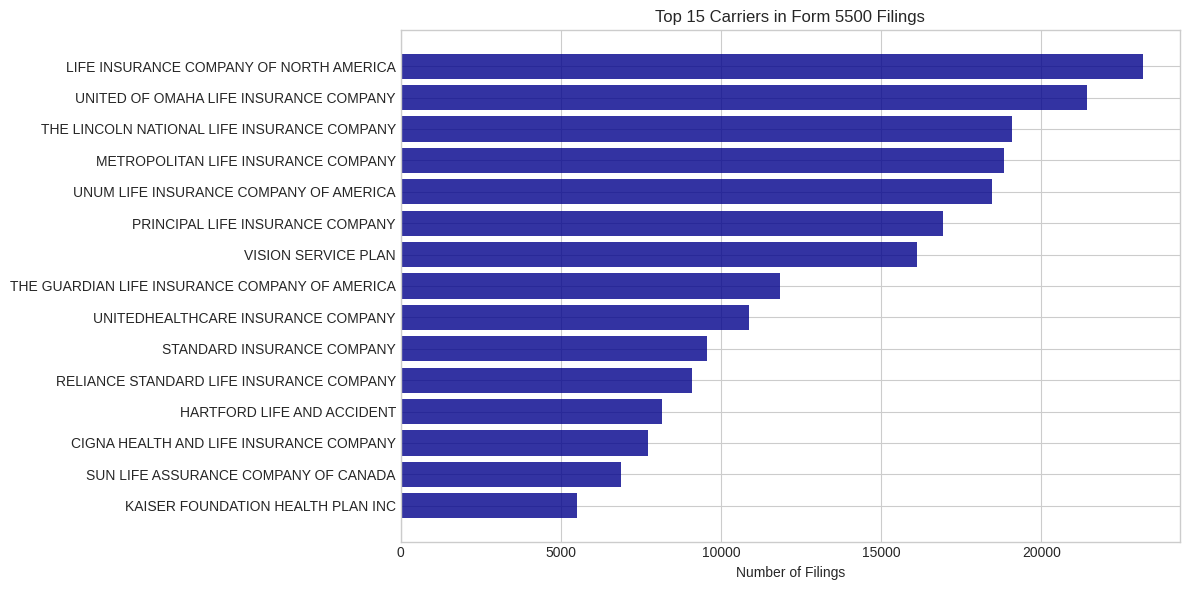

In [19]:
# Visualize top carriers
fig, ax = plt.subplots(figsize=(12, 6))
top_15_carriers = top_carriers.head(15)

bars = ax.barh(range(len(top_15_carriers)), top_15_carriers.values, color='darkblue', alpha=0.8)
ax.set_yticks(range(len(top_15_carriers)))
ax.set_yticklabels(top_15_carriers.index)
ax.invert_yaxis()
ax.set_xlabel('Number of Filings')
ax.set_title('Top 15 Carriers in Form 5500 Filings')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}top_carriers.png', dpi=150)
plt.show()

Available benefit columns: ['is_health', 'is_dental', 'is_vision', 'is_life', 'is_std', 'is_ltd', 'is_disability', 'is_unemployment', 'is_drug', 'is_stop_loss', 'has_accident', 'has_critical_illness', 'has_hospital_indemnity', 'has_add', 'has_eap', 'has_legal', 'has_ltc', 'has_telehealth']


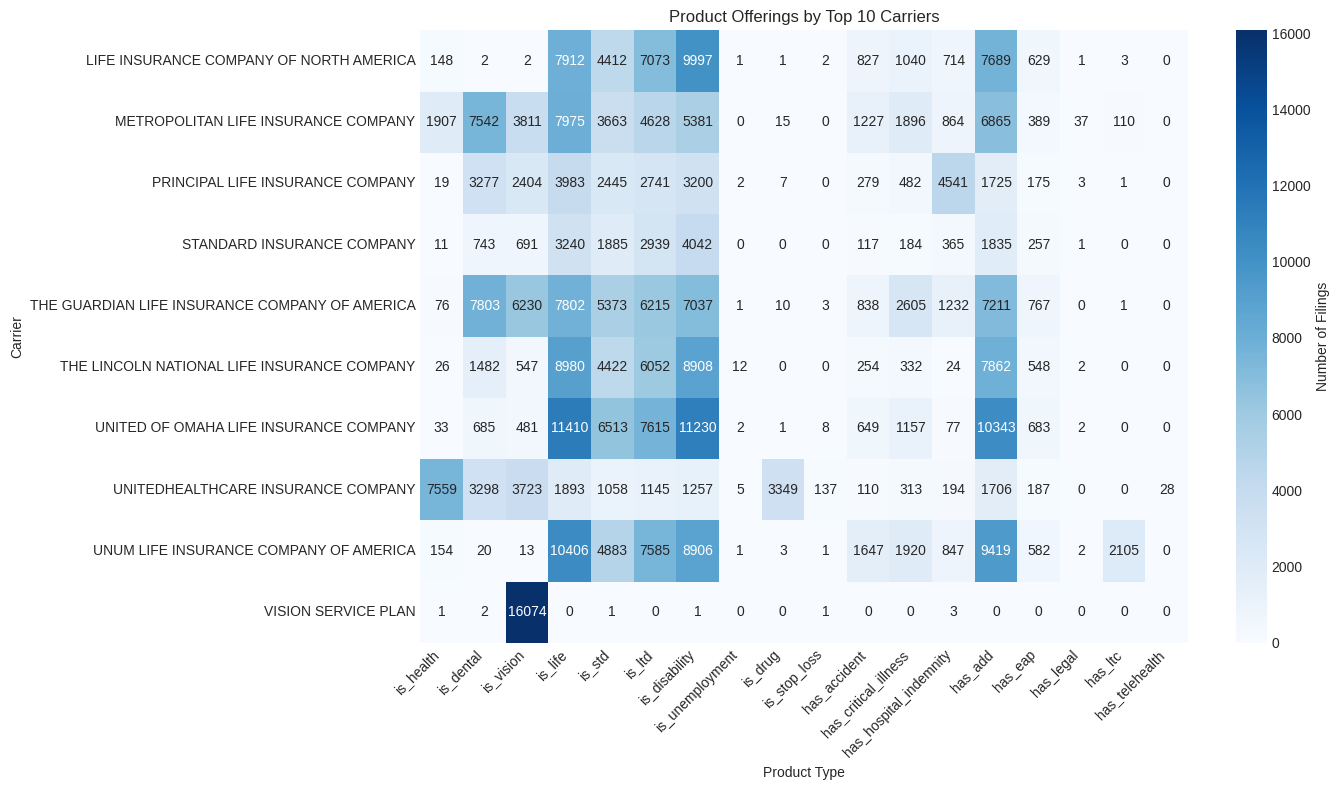

In [20]:
# Product offerings by carriers - which products do top carriers offer?
benefit_cols = ['is_health', 'is_dental', 'is_vision', 'is_life', 'is_std', 'is_ltd', 
                'is_disability', 'is_unemployment', 'is_drug', 'is_stop_loss',
                'has_accident', 'has_critical_illness', 'has_hospital_indemnity', 
                'has_add', 'has_eap', 'has_legal', 'has_ltc', 'has_telehealth']

# Check which benefit columns exist
existing_benefit_cols = [col for col in benefit_cols if col in fact_carrier.columns]
print(f"Available benefit columns: {existing_benefit_cols}")

# Get top 10 carriers and their product offerings
top_carrier_names = top_carriers.head(10).index.tolist()
carrier_products = fact_carrier[fact_carrier['carrier_name'].isin(top_carrier_names)].groupby('carrier_name')[existing_benefit_cols].sum()

if len(carrier_products) > 0:
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.heatmap(carrier_products, annot=True, fmt='.0f', cmap='Blues', ax=ax, cbar_kws={'label': 'Number of Filings'})
    ax.set_title('Product Offerings by Top 10 Carriers')
    ax.set_xlabel('Product Type')
    ax.set_ylabel('Carrier')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}carrier_products_heatmap.png', dpi=150)
    plt.show()

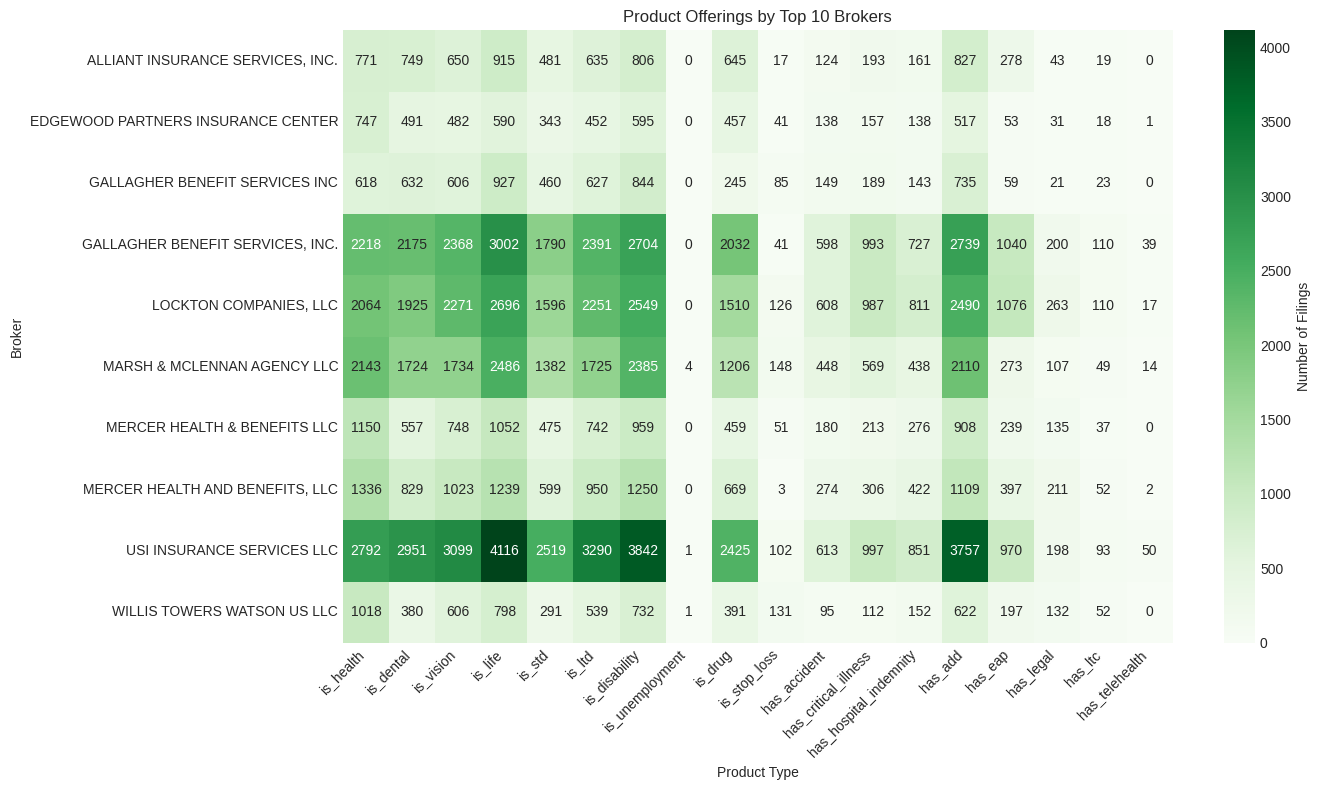

In [21]:
# Broker product offerings
top_broker_names = top_brokers.head(10).index.tolist()
broker_products = fact_carrier[fact_carrier['broker_name'].isin(top_broker_names)].groupby('broker_name')[existing_benefit_cols].sum()

if len(broker_products) > 0:
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.heatmap(broker_products, annot=True, fmt='.0f', cmap='Greens', ax=ax, cbar_kws={'label': 'Number of Filings'})
    ax.set_title('Product Offerings by Top 10 Brokers')
    ax.set_xlabel('Product Type')
    ax.set_ylabel('Broker')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}broker_products_heatmap.png', dpi=150)
    plt.show()

## Additional EDA: Premium Analysis

In [22]:
# Premium analysis by carrier
carrier_premiums = fact_carrier.groupby('carrier_name').agg({
    'premium': 'sum',
    'persons_covered': 'sum',
    'broker_commission': 'sum',
    'ein': 'nunique'
}).rename(columns={'ein': 'num_companies'})

carrier_premiums['premium_per_life'] = carrier_premiums['premium'] / carrier_premiums['persons_covered'].replace(0, np.nan)
carrier_premiums['commission_rate'] = carrier_premiums['broker_commission'] / carrier_premiums['premium'].replace(0, np.nan) * 100

print("Top Carriers by Total Premium Volume:")
print(carrier_premiums.sort_values('premium', ascending=False).head(15))

Top Carriers by Total Premium Volume:
                                                         premium  \
carrier_name                                                       
UNITEDHEALTHCARE INSURANCE COMPANY                  1.933661e+10   
METROPOLITAN LIFE INSURANCE COMPANY                 1.473525e+10   
KAISER FOUNDATION HEALTH PLAN INC                   1.192482e+10   
CIGNA HEALTH AND LIFE INSURANCE COMPANY             8.848589e+09   
AETNA LIFE INSURANCE COMPANY                        8.298229e+09   
KAISER FOUNDATION HEALTH PLAN INC.                  6.928828e+09   
UNITED HEALTHCARE INSURANCE COMPANY                 6.907852e+09   
CIGNA HEALTH AND LIFE INSURANCE COMPANY AND AFF...  6.475253e+09   
AETNA LIFE INSURANCE CO.                            6.220276e+09   
HARTFORD LIFE AND ACCIDENT                          5.296116e+09   
BLUE CROSS OF CALIFORNIA                            5.282685e+09   
PRUDENTIAL INSURANCE COMPANY OF AMERICA             4.841527e+09   
UNUM LIFE 

Premium Per Life by Sector:
                                                       premium  \
sector                                                           
Construction                                      1.954747e+10   
Professional, Scientific, and Technical Services  9.900021e+10   
Accommodation and Food Services                   1.358213e+10   
Finance and Insurance                             1.165704e+11   
Health Care and Social Assistance                 1.211482e+11   
Manufacturing                                     1.204750e+11   
Information                                       3.955396e+10   
Other Services (except Public Administration)     1.723672e+10   
Transportation and Warehousing                    2.295129e+10   
Retail Trade                                      4.734636e+10   

                                                  persons_covered  \
sector                                                              
Construction                             

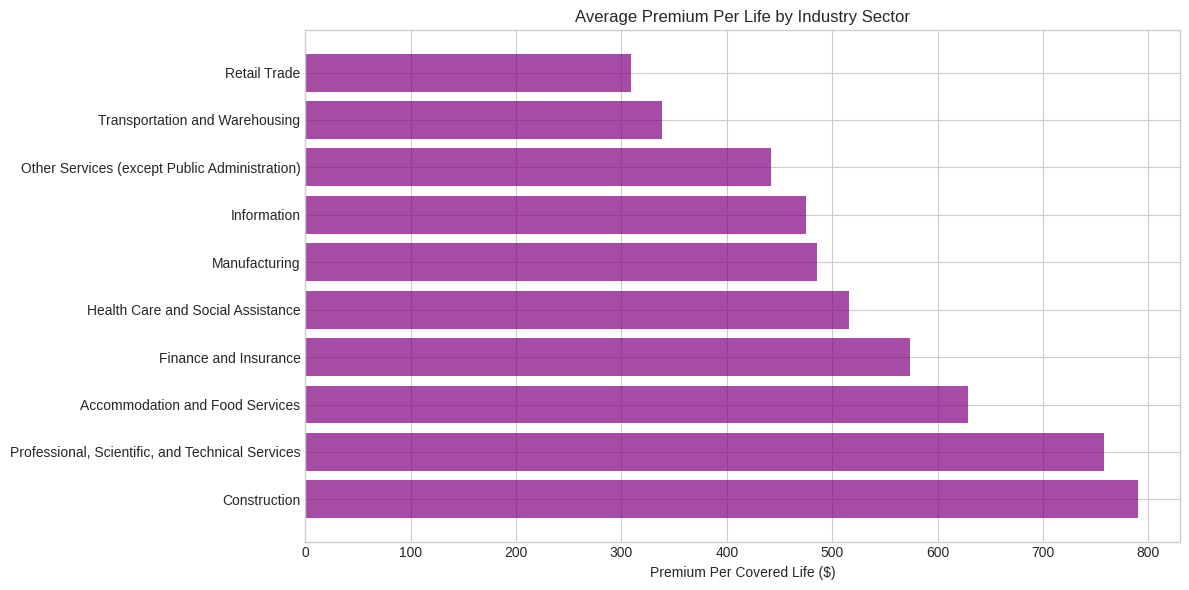

In [23]:
# Premium per life by industry sector (only if we have sector data)
if len(sector_dist) > 0 and fact_filing['sector'].notna().sum() > 0:
    fact_filing_with_carrier = fact_filing.merge(
        fact_carrier[['ein', 'premium', 'persons_covered']].groupby('ein').agg({'premium': 'sum', 'persons_covered': 'sum'}).reset_index(),
        on='ein', 
        how='left'
    )
    
    premium_by_sector = fact_filing_with_carrier.groupby('sector').agg({
        'premium': 'sum',
        'persons_covered': 'sum'
    }).dropna()
    
    premium_by_sector = premium_by_sector[premium_by_sector['persons_covered'] > 0]
    
    if len(premium_by_sector) > 0:
        premium_by_sector['premium_per_life'] = premium_by_sector['premium'] / premium_by_sector['persons_covered']
        premium_by_sector = premium_by_sector.sort_values('premium_per_life', ascending=False)
        
        print("Premium Per Life by Sector:")
        print(premium_by_sector)
        
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.barh(range(len(premium_by_sector)), premium_by_sector['premium_per_life'], color='purple', alpha=0.7)
        ax.set_yticks(range(len(premium_by_sector)))
        ax.set_yticklabels(premium_by_sector.index)
        ax.set_xlabel('Premium Per Covered Life ($)')
        ax.set_title('Average Premium Per Life by Industry Sector')
        plt.tight_layout()
        plt.savefig(f'{OUTPUT_DIR}premium_per_life_sector.png', dpi=150)
        plt.show()
    else:
        print("Not enough premium data by sector")
else:
    print("Sector data not available for premium analysis")

## Additional EDA: Geographic Distribution

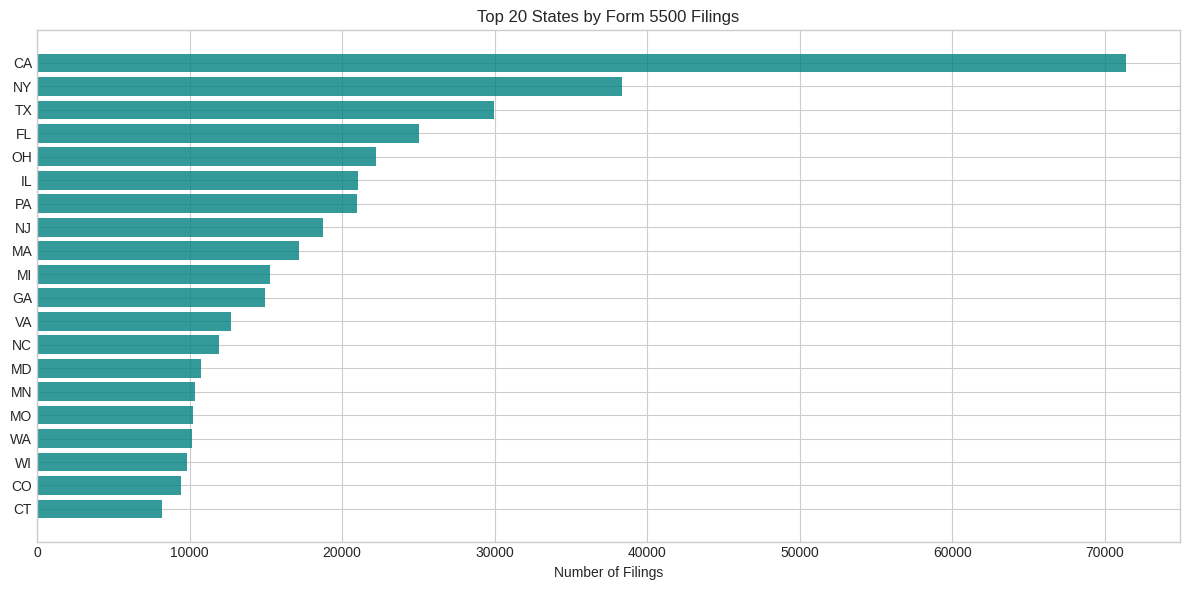


Top 20 States:
state
CA    71358
NY    38373
TX    29983
FL    25008
OH    22226
IL    21023
PA    20968
NJ    18756
MA    17193
MI    15278
GA    14924
VA    12689
NC    11938
MD    10746
MN    10326
MO    10209
WA    10143
WI     9832
CO     9430
CT     8194
Name: count, dtype: int64


In [24]:
# Geographic distribution by state
state_dist = fact_filing['state'].value_counts().head(20)

fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(range(len(state_dist)), state_dist.values, color='teal', alpha=0.8)
ax.set_yticks(range(len(state_dist)))
ax.set_yticklabels(state_dist.index)
ax.invert_yaxis()
ax.set_xlabel('Number of Filings')
ax.set_title('Top 20 States by Form 5500 Filings')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}state_distribution.png', dpi=150)
plt.show()

print("\nTop 20 States:")
print(state_dist)

## Summary Statistics & Key Findings

In [25]:
# Create summary dataframe
summary_data = {
    'Metric': [
        'Total Filings (sample)',
        'Unique Companies (sample)',
        'Unique Plans (sample)',
        'Years Covered (Raw Data)',
        'Unique Carriers (sample)',
        'Unique Brokers (sample)',
        'Unique NAICS Codes',
        'Average Plan Size (participants)',
        'Median Plan Size (participants)',
        'Welfare Filings',
        'Pension Filings'
    ],
    'Value': [
        len(fact_filing),
        fact_filing['ein'].nunique(),
        fact_filing['plan_number'].nunique(),
        "2020-2024",
        fact_carrier['carrier_name'].nunique(),
        fact_carrier['broker_name'].nunique(),
        fact_filing['business_code'].nunique(),
        f"{fact_filing['total_all_participants'].mean():.0f}",
        f"{fact_filing['total_all_participants'].median():.0f}",
        fact_filing['is_welfare'].sum(),
        fact_filing['is_pension'].sum()
    ]
}

summary_df = pd.DataFrame(summary_data)

print("=== SUMMARY STATISTICS ===\n")
print(summary_df.to_string(index=False))

# Save summary
summary_df.to_csv(f'{OUTPUT_DIR}summary_statistics.csv', index=False)
print(f"\nSummary saved to {OUTPUT_DIR}summary_statistics.csv")

=== SUMMARY STATISTICS ===

                          Metric     Value
          Total Filings (sample)    500000
       Unique Companies (sample)    419872
           Unique Plans (sample)       845
        Years Covered (Raw Data) 2020-2024
        Unique Carriers (sample)     12844
         Unique Brokers (sample)     30984
              Unique NAICS Codes       706
Average Plan Size (participants)       183
 Median Plan Size (participants)        11
                 Welfare Filings     73677
                 Pension Filings    421818

Summary saved to eda_output/summary_statistics.csv


In [26]:
# Save key data exports for future analysis
print("Saving key data exports...")

# Company-level summary
company_summary = dim_company[['ein', 'company_name', 'state', 'plan_size', 'industry_sector', 
                                'total_employees', 'benefits_eligible', 'unique_carriers', 
                                'unique_brokers', 'total_filings_count', 'has_welfare_filings', 
                                'has_pension_filings']].copy()
company_summary.to_csv(f'{OUTPUT_DIR}company_summary.csv', index=False)
print(f"Company summary saved: {len(company_summary)} companies")

# NAICS sector mapping
naics_sector = dim_naics[['naics_code', 'industry_name', 'sector_name', 'sector_code']].copy()
naics_sector.to_csv(f'{OUTPUT_DIR}naics_sector_mapping.csv', index=False)
print(f"NAICS mapping saved: {len(naics_sector)} codes")

# Broker-carrier relationships
broker_carrier = fact_carrier[['broker_name', 'carrier_name', 'is_health', 'is_dental', 
                                'is_vision', 'is_life', 'premium', 'broker_commission']].copy()
broker_carrier.to_csv(f'{OUTPUT_DIR}broker_carrier_products.csv', index=False)
print(f"Broker-carrier data saved: {len(broker_carrier)} records")

Saving key data exports...
Company summary saved: 1063215 companies
NAICS mapping saved: 374 codes
Broker-carrier data saved: 500000 records


## Clustering Model Recommendations

Based on this EDA, here are recommended clustering approaches for company segmentation and benefits insurance scoring:

### 1. **K-Means Clustering**
- Best for: Initial segmentation with spherical clusters
- Features: Company size (employees, participants), number of carriers, number of products, premium totals
### 2. **Hierarchical Clustering**
- Best for: Understanding industry-specific groupings
- Features: NAICS sector codes, benefit types offered
- Can reveal nested industry relationships

### 3. **DBSCAN**
- Best for: Finding natural clusters without pre-specifying k
- Good for: Identifying outliers in benefits programs (companies with unusual offerings)

### 4. **Gaussian Mixture Models (GMM)**
- Best for: Probabilistic cluster assignments
- Useful when: Companies can belong to multiple benefit program categories

### Key Features for Clustering:

**Size Features:**
- `total_all_participants` - Plan participant count
- `benefits_eligible` - Employees eligible for benefits
- Plan size category (small/large)

**Industry Features:**
- NAICS sector (first 2 digits)
- NAICS subsector (first 3 digits)
- Multi-sector indicator

**Benefits Program Features:**
- Number of unique carriers
- Number of unique brokers
- Product types (health, dental, vision, life, etc.)
- Welfare vs pension indicators
- Total premiums

**Geographic Features:**
- State/region
- Could combine with industry to find regional patterns

### Suggested Next Steps:
1. Feature engineering: Create binary indicators for each product type
2. Feature scaling: Normalize participant counts and premium values
3. Dimensionality reduction: Consider PCA if features are highly correlated
4. Cluster validation: Use silhouette score or elbow method to determine optimal k
5. Build scoring model: Once clusters are defined, score each company based on benefits complexity and premium levels
